In [1]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d

In [2]:
TIME_STEP = 1/1000
CLIP_IERR = 100

In [3]:
class Plant:
    
    def __init__(self, noise_scale=0, noise_decay=0, noise_momentum=0.5):
        self.__x = 0
        self.__y = 0
        self.__z = 0
        self.__vx = 0
        self.__vy = 0
        self.__vz = 0
        self.__noise_scale = noise_scale
        self.__noise_decay = noise_decay
        self.__noise_momentum = noise_momentum
        self.noise = np.zeros(3)
    
    def step(self, ax, ay, az):
        noise = np.random.randn(3) * self.__noise_scale
        self.noise = \
            self.__noise_momentum*self.noise + \
            (1-self.__noise_momentum)*noise
        self.noise *= 1-self.__noise_decay
        ax += self.noise[0]
        ay += self.noise[1]
        az += self.noise[2]
        self.__x += self.__vx*TIME_STEP + 0.5*ax*TIME_STEP**2
        self.__y += self.__vy*TIME_STEP + 0.5*ay*TIME_STEP**2
        self.__z += self.__vz*TIME_STEP + 0.5*az*TIME_STEP**2
        self.__vx += ax*TIME_STEP
        self.__vy += ay*TIME_STEP
        self.__vz += az*TIME_STEP
        return self.__x, self.__y, self.__z

In [4]:
class PIDController:
    
    def __init__(self, Kp, Ki, Kd, clip_ierr=None):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.ierr = 0
        self.__prev_err = 0
        self.__clip_ierr = clip_ierr
    
    def step(self, measured, desired):
        err = desired - measured
        self.ierr = self.ierr + err*TIME_STEP
        if self.__clip_ierr is not None:
            self.ierr = np.clip(self.ierr, -self.__clip_ierr, self.__clip_ierr)
        derr = (err-self.__prev_err)/TIME_STEP
        self.__prev_err = err
        return self.Kp*err + self.Ki*self.ierr + self.Kd*derr

In [5]:
class Target:
    
    def __init__(self, scale=1, momentum=0.5):
        self.__plant = Plant(noise_scale=0)
        self.__scale = scale
        self.__momentum = momentum
        self.__a = np.zeros((3,))
    
    def step(self):
        self.__a = self.__a*self.__momentum + \
            (1-self.__momentum)*np.random.randn(3)
        return self.__plant.step(*self.__a*self.__scale)

final noise -0.7165806703658527 0.7902556237666098 -2.555624868004322
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err 4.849897918610431 -5.184070745598206 -0.31103586984846743


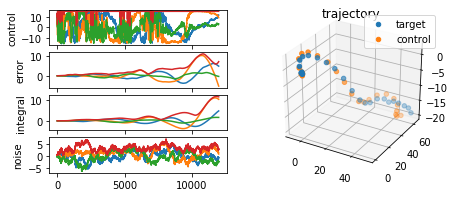

In [32]:
Kp,Ki,Kd = 10,100,35
control_max = 15
plant = Plant(noise_scale=100, noise_decay=0, noise_momentum=0.999)
target = Target(scale=100, momentum=0.5)
pid_x, pid_y, pid_z = [PIDController(Kp,Ki,Kd,clip_ierr=CLIP_IERR) for _ in range(3)]
x,y,z = plant.step(0,0,0)
T, Y, C, E, I, N = [[] for _ in range(6)]
for t in range(12000):
    tx,ty,tz = target.step()
    cx = pid_x.step(x,tx)
    cy = pid_y.step(y,ty)
    cz = pid_z.step(z,tz)
    clen = np.linalg.norm((cx,cy,cz))
    if clen > control_max:
        cx,cy,cz = np.array([cx,cy,cz])/clen*control_max
    x,y,z = plant.step(cx,cy,cz)
    T.append((tx,ty,tz))
    Y.append((x,y,z))
    C.append((cx,cy,cz,np.linalg.norm((cx,cy,cz))))
    E.append((tx-x,ty-y,tz-z,np.linalg.norm((tx-x,ty-y,tz-z))))
    I.append((pid_x.ierr,pid_y.ierr,pid_z.ierr,np.linalg.norm((pid_x.ierr,pid_y.ierr,pid_z.ierr))))
    N.append((*plant.noise,np.linalg.norm(plant.noise)))
print('final noise', *plant.noise)
print('final ierr', pid_x.ierr, pid_y.ierr, pid_z.ierr)
print('final err', tx-x, ty-y, tz-z)
plt.figure(figsize=(7,3))
ax = plt.subplot(122, projection='3d'); plt.title('trajectory')
ax.scatter(*np.moveaxis(T[::500],0,-1)); ax.scatter(*np.moveaxis(Y[::500],0,-1))
plt.legend(['target', 'control'])
plt.subplot(421); plt.ylabel('control'); plt.plot(C)
plt.subplot(423); plt.ylabel('error'); plt.plot(E)
plt.subplot(425); plt.ylabel('integral'); plt.plot(I)
plt.subplot(427); plt.ylabel('noise'); plt.plot(N)
plt.show()

In [7]:
import keras
import keras.backend as K

/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
class PIDCell(keras.layers.Layer):
    
    def __init__(self, units, clip_ierr=None, **kwargs):
        self.units = units
        self.state_size = (units, units)
        self.__clip_ierr = clip_ierr
        super(PIDCell, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.built = True
    
    def call(self, inputs, states):
        dt, err, Kp, Ki, Kd = inputs[:,0:1], \
            inputs[:,1:self.units+1],inputs[:,self.units+1:self.units+2], \
            inputs[:,self.units+2:self.units+3],inputs[:,self.units+3:self.units+4]
        perr, ierr = states
        ierr = ierr+err*dt
        if self.__clip_ierr is not None:
            ierr = K.clip(ierr, -self.__clip_ierr, self.__clip_ierr)
        derr = (err-perr)/dt
        perr = err
        return K.softplus(Kp)*err + K.softplus(Ki)*ierr + K.softplus(Kd)*derr, [perr, ierr]

In [34]:
X_input_dt = keras.layers.Input((None, 1), batch_shape=(1,1,1))
X_input_err = keras.layers.Input((None, 3), batch_shape=(1,1,3))
X_input_tar = keras.layers.Input((None, 3), batch_shape=(1,1,3))
X = keras.layers.Concatenate()([X_input_err,X_input_tar])
X = keras.layers.LSTM(64, stateful=True, return_sequences=True)(X)
X_Kp = keras.layers.TimeDistributed(keras.layers.Dense(1, kernel_initializer='he_normal'))(X)
X_Ki = keras.layers.TimeDistributed(keras.layers.Dense(1, kernel_initializer='he_normal'))(X)
X_Kd = keras.layers.TimeDistributed(keras.layers.Dense(1, kernel_initializer='he_normal'))(X)
X = keras.layers.Concatenate()([X_input_dt,X_input_err,X_Kp,X_Ki,X_Kd])
X_pid,_,X_ierr = keras.layers.RNN(PIDCell(3, clip_ierr=CLIP_IERR), stateful=True, return_sequences=True, return_state=True)(X)
X_Kp = keras.layers.Lambda(lambda x: K.softplus(x))(X_Kp)
X_Ki = keras.layers.Lambda(lambda x: K.softplus(x))(X_Ki)
X_Kd = keras.layers.Lambda(lambda x: K.softplus(x))(X_Kd)
M_control = keras.Model([X_input_dt,X_input_err,X_input_tar], X_pid)
M_control.compile('adam', 'mse')
M_control_freeze = keras.Model(
    [X_input_dt,X_input_err,X_input_tar],
    [X_pid,X_ierr,X_Kp,X_Ki,X_Kd])
M_control_freeze.trainable = False
M_control_freeze.compile('adam', 'mse')
M_control.summary()

X_input_ctl = keras.layers.Input((None, 3), batch_shape=(1,1,3))
X = keras.layers.Concatenate()([X_input_err,X_input_tar,X_input_ctl])
X = keras.layers.TimeDistributed(keras.layers.Dense(256, activation='sigmoid', kernel_initializer='glorot_normal'))(X)
X = keras.layers.LSTM(128, stateful=True, return_sequences=True)(X)
X = keras.layers.TimeDistributed(keras.layers.Dense(3, kernel_initializer='he_normal'))(X)
M_plant = keras.Model([X_input_err,X_input_tar,X_input_ctl], X)
M_plant.compile('adam', 'mse')
M_plant_freeze = keras.Model([X_input_err,X_input_tar,X_input_ctl], X)
M_plant_freeze.trainable = False
M_plant_freeze.compile('adam', 'mse')
M_plant.summary()

X = M_control([X_input_dt,X_input_err,X_input_tar])
X = M_plant_freeze([X_input_err,X_input_tar,X])
M_train = keras.Model([X_input_dt,X_input_err,X_input_tar], X)
M_train.compile('adam', 'mse')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (1, 1, 3)            0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (1, 1, 3)            0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (1, 1, 6)            0           input_10[0][0]                   
                                                                 input_11[0][0]                   
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (1, 1, 64)           18176       concatenate_7[0][0]              
__________

final noise -2.4250700071351243 0.772122665037001 2.2719001293688548
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err 19.761744559246768 -13.007326043088781 8.37155626219159


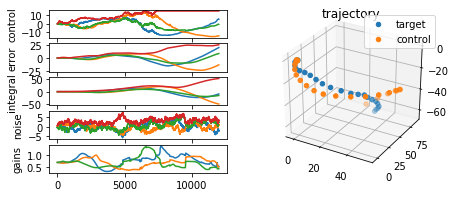

plant model loss [5.328224506229162e-05]
trainning model loss [218.7310791015625]
final noise 0.9404287644936722 0.5399219321085142 1.262237385693757
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err 99.38743149784945 -81.47180509418101 76.96880349510863


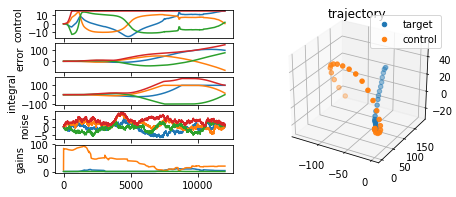

plant model loss [9.936260903486982e-05]
trainning model loss [5347.18701171875]
final noise 0.9670105433755442 4.389405462290771 0.33480247532126944
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err -73.63442620469311 -37.45795432364302 26.413591649319386


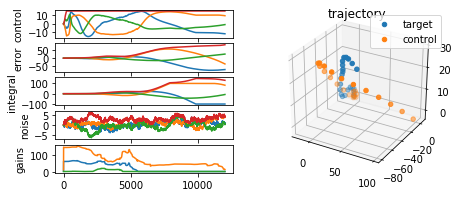

plant model loss [0.0007535224431194365]
trainning model loss [2442.203857421875]
final noise -2.9923683112941224 -1.710116599417363 2.075997254427062
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err 7.586032720673579 0.6783424670208902 -207.4532848864756


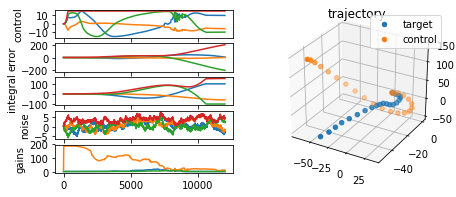

plant model loss [0.09337801486253738]
trainning model loss [14608.24609375]
final noise -3.790122081587741 1.8700985215008425 -0.059872573569430945
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err -6.271118042652343 1.123589805128626 -5.4802488989863605


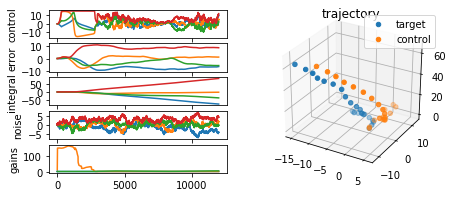

plant model loss [1.2599181900441181e-05]
trainning model loss [23.5568790435791]
final noise -2.3637153418796797 0.5179801417547049 2.0113923731433534
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err -70.06686753904333 49.65839988244 23.093026896366037


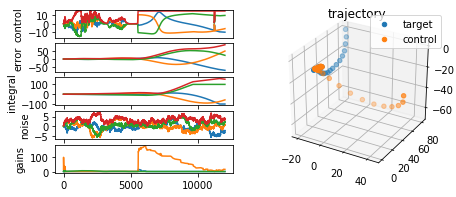

plant model loss [0.0007883491925895214]
trainning model loss [2714.777099609375]
final noise 0.36855244532452974 -0.647107048313921 2.872839972527043
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err -88.1737979655646 94.55689945930627 -50.174301608695


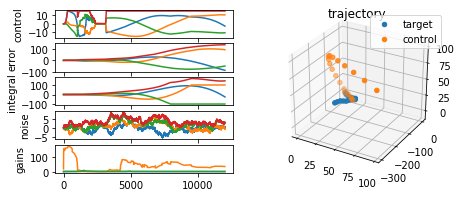

plant model loss [0.0017914163181558251]
trainning model loss [6804.94384765625]
final noise -1.6265766724319435 0.7877283797739943 -2.2199022382345284
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err -6.107779553183262 -6.927312476709755 11.804163100307719


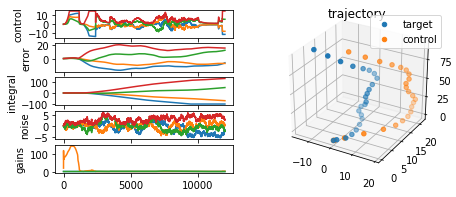

plant model loss [9.036195115186274e-05]
trainning model loss [55.77094650268555]
final noise 4.6748869518827965 1.3166376481681006 0.8277474772739526
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err -3.4349424129693205 -9.082467788022925 -2.584073413884326


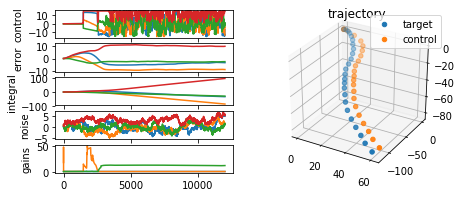

plant model loss [7.2510411008863684e-09]
trainning model loss [33.607173919677734]
final noise -1.2318677978057921 -2.6022662266115066 -0.0002864593739475771
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err -4.346459601004042 0.4218464859600388 0.4662707082969817


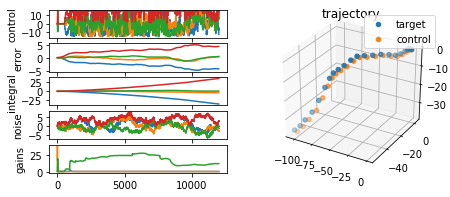

plant model loss [1.5863834050833248e-06]
trainning model loss [6.423813343048096]
final noise 0.3599550969630658 -2.6444485753976426 2.6400415686825145
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err -18.018197507605578 17.105124104534067 -5.662390242978793


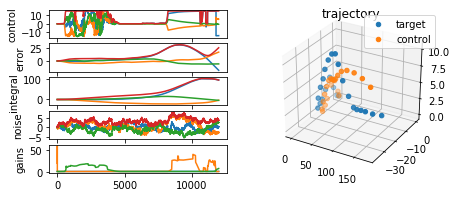

plant model loss [0.032960209995508194]
trainning model loss [53.77479934692383]
final noise 2.1219005795590133 -1.2982598930996694 0.7395083457892234
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err -6.2469150351453635 1.4358897369598935 7.631450903138102


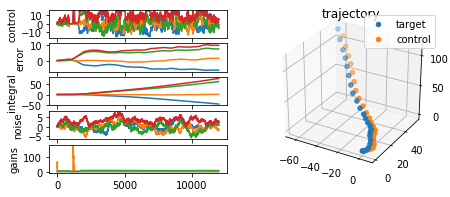

plant model loss [2.4568553271819837e-05]
trainning model loss [32.88768005371094]
final noise 1.7101334564579678 -2.4980420272444146 -0.10320348220843864
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err -2.751236898284276 1.1117888292267324 4.341518820955287


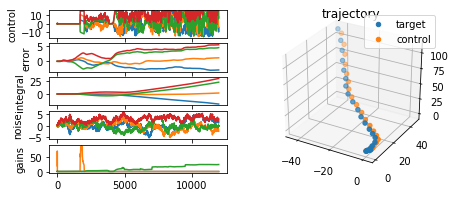

plant model loss [4.692916263593361e-06]
trainning model loss [9.163535118103027]
final noise -0.8156185393824475 -1.019181162551648 -2.515293361691891
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err -0.818640498624049 0.9177106726195561 1.1857298571909993


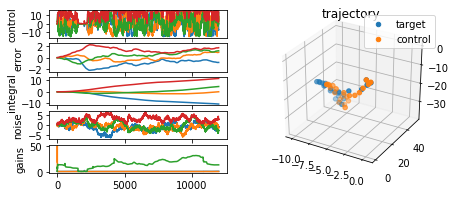

plant model loss [2.9112047172930033e-07]
trainning model loss [0.9742154479026794]
final noise -0.9628134498435454 3.906916042334245 1.0552312481023598
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err -1.3477762931947268 0.6758887657388684 3.728703500987251


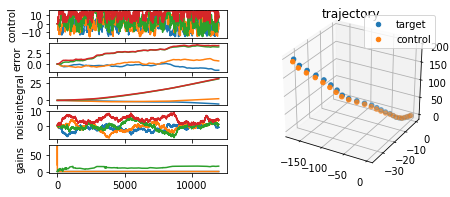

plant model loss [6.924447237821596e-09]
trainning model loss [5.05842399597168]
final noise 0.14609859597754543 1.1736081559491434 -4.049240793328959
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err 1.1380805687042823 -17.71617680461988 0.08106224709014498


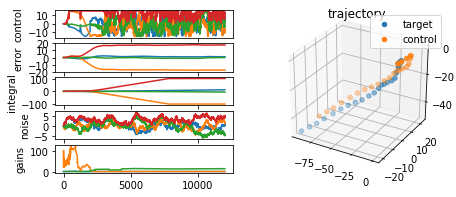

plant model loss [1.1619955557762296e-06]
trainning model loss [102.94866180419922]
final noise 1.324618748261257 -2.24835355186821 0.012321280758660597
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err 0.023610591915030454 -0.08749684519330714 -0.4078186624662834


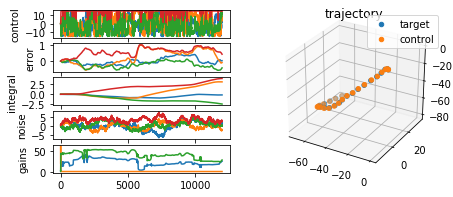

plant model loss [6.402608050848357e-06]
trainning model loss [0.057540882378816605]
final noise 0.6903849954574666 1.5295101575606205 0.3418171989713966
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err -15.508599276582522 -4.820037034514712 1.8784281540943155


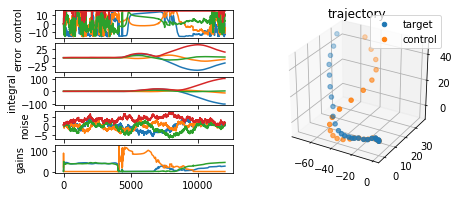

plant model loss [8.64753092173487e-05]
trainning model loss [88.88690948486328]
final noise -0.3249900423546943 -3.8865993910134145 1.7955868555551695
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err 0.7316771023097743 1.7237506042148638 1.0177666253759554


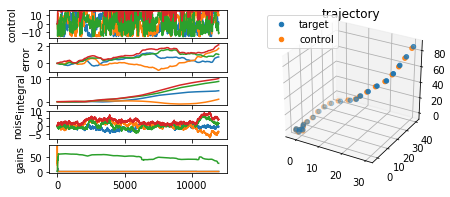

plant model loss [2.3380055154120782e-06]
trainning model loss [1.510208010673523]
final noise -0.6891123575174356 -2.119659460676244 2.624545944147426
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err -0.8283384204629414 2.536294149319673 2.341564290534606


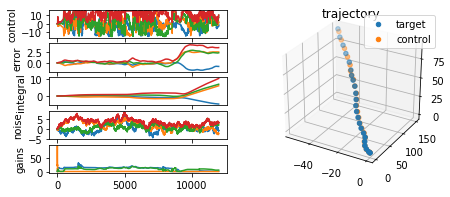

plant model loss [1.6999501895043068e-05]
trainning model loss [4.183038234710693]
final noise -1.3957504104241782 -2.538295411430568 2.7968450523076607
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err -0.043431616243083226 0.40973983116962565 -0.11327501910904125


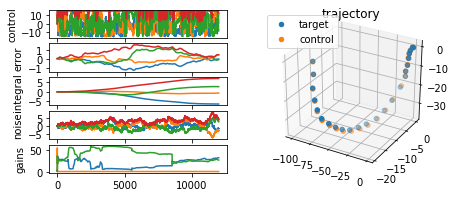

plant model loss [3.400729156055604e-06]
trainning model loss [0.0602237768471241]
final noise 1.8047052466846338 0.9576001487519094 -0.7187278840685989
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err -0.21508154457145423 -0.5366417969341626 0.2002849098702626


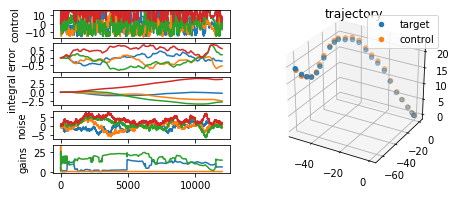

plant model loss [2.0135191292069976e-08]
trainning model loss [0.1248299703001976]
final noise -2.5033419005693913 -0.8378170919816743 -2.0886369885477376
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err 0.0867484753303529 0.5364383253191889 0.8013964210863804


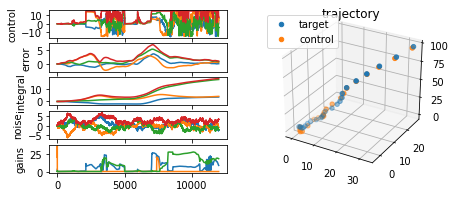

plant model loss [2.269120074060993e-07]
trainning model loss [0.3139495849609375]
final noise 1.8101975743752772 -3.9914503435830007 0.9874650868097619
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err 0.22890422447904513 2.7098393827770515 -0.2265735944728089


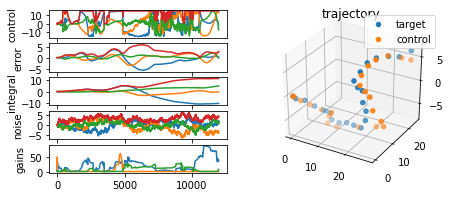

plant model loss [1.0384568582821885e-07]
trainning model loss [2.4908041954040527]
final noise -1.427841540804153 -1.5661036645440245 1.512738881995141
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err -0.21682213227327907 -1.0068828686616929 -1.571936335252543


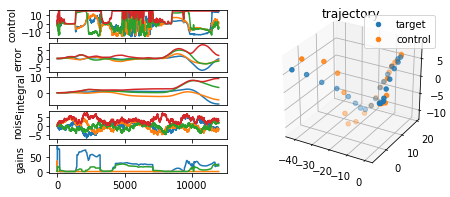

plant model loss [1.4855371155420016e-08]
trainning model loss [1.1733607053756714]
final noise 1.5808185713179626 -1.5652800453009772 2.3701147431364626
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err -3.2967830377145617 0.5019465915634527 0.8856310268234999


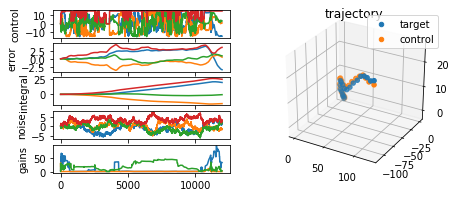

plant model loss [5.50239235508343e-07]
trainning model loss [3.9988653659820557]
final noise 1.722368317391824 1.9727914133192543 -2.5462476229251134
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err 2.107403637865165 -0.17128869464863783 -1.5678088679593998


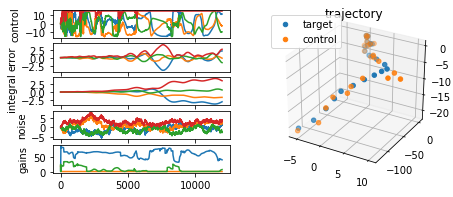

plant model loss [4.703312299625395e-07]
trainning model loss [2.312030076980591]
final noise -0.5021234965594984 2.2561126185225517 0.6981209917520348
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err -1.8601854419876518 0.17095478602157854 -0.4184905307067055


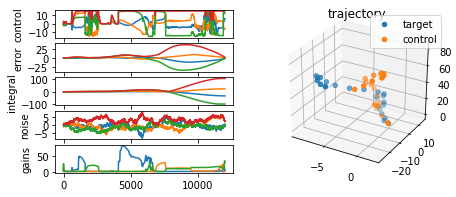

plant model loss [2.0789184418390505e-06]
trainning model loss [1.2045856714248657]
final noise -2.2983441992545415 -2.8873807936456015 0.381344663617724
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err 2.323302876960593 0.9001663362427657 -1.5140241573764257


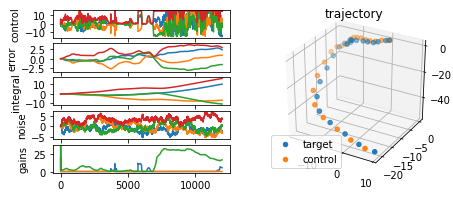

plant model loss [2.499820652701601e-07]
trainning model loss [2.831336259841919]
final noise 0.5795521135321122 3.666525199050808 -0.8963541345255275
final ierr 4.802535214437272 10.455545782087187 1.6536988019278422
final err 1.6018634626652783 -0.8433573015234543 -0.7733796304576828


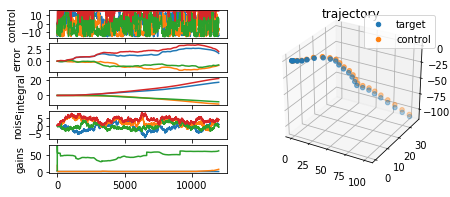

plant model loss [1.064345269696787e-06]
trainning model loss [1.290448546409607]
3min 9s ± 0 ns per loop (mean ± std. dev. of 1 run, 30 loops each)


In [35]:
%%timeit -n 30 -r 1

control_max = 15
plant = Plant(noise_scale=100, noise_decay=0, noise_momentum=0.999)
target = Target(scale=100, momentum=0.5)
x,y,z = plant.step(0,0,0)
ex,ey,ez = 0,0,0
T, Y, C, E, I, N, G = [[] for _ in range(7)]
M_control_freeze.reset_states()
for t in range(12000):
    tx,ty,tz = target.step()
    ctl,ierr,Kp,Ki,Kd = M_control_freeze.predict([
        np.array([[[TIME_STEP]]]),
        np.array([[[ex,ey,ez]]]),
        np.array([[[tx,ty,tz]]])-np.array([[[x,y,z]]])])
    cx,cy,cz = ctl[0,0]
    iex,iey,iez = ierr[0]
    clen = np.linalg.norm((cx,cy,cz))
    if clen > control_max:
        cx,cy,cz = np.array([cx,cy,cz])/clen*control_max
    x,y,z = plant.step(cx,cy,cz)
    ex,ey,ez = tx-x,ty-y,tz-z
    T.append((tx,ty,tz))
    Y.append((x,y,z))
    C.append((cx,cy,cz,np.linalg.norm((cx,cy,cz))))
    E.append((ex,ey,ez,np.linalg.norm((ex,ey,ez))))
    I.append((iex,iey,iez,np.linalg.norm((iex,iey,iez))))
    N.append((*plant.noise,np.linalg.norm(plant.noise)))
    G.append((Kp[0,0,0],Ki[0,0,0],Kd[0,0,0]))
print('final noise', *plant.noise)
print('final ierr', pid_x.ierr, pid_y.ierr, pid_z.ierr)
print('final err', ex, ey, ez)
plt.figure(figsize=(7,3))
ax = plt.subplot(122, projection='3d'); plt.title('trajectory')
ax.scatter(*np.moveaxis(T[::500],0,-1)); ax.scatter(*np.moveaxis(Y[::500],0,-1))
plt.legend(['target', 'control'])
plt.subplot(521); plt.ylabel('control'); plt.plot(C)
plt.subplot(523); plt.ylabel('error'); plt.plot(E)
plt.subplot(525); plt.ylabel('integral'); plt.plot(I)
plt.subplot(527); plt.ylabel('noise'); plt.plot(N)
plt.subplot(529); plt.ylabel('gains'); plt.plot(G)
plt.show()

M_plant.reset_states()
for e,t,y,c,l in zip(E[:-1], T[1:], Y[:-1], C[1:], E[1:]):
    history = M_plant.fit(
        [np.array([[e[:3]]]),np.array([[t[:3]]])-np.array([[y[:3]]]),np.array([[c[:3]]])],
        np.array([[l[:3]]]), batch_size=1, shuffle=False, verbose=0)
print('plant model loss', history.history['loss'])

M_train.reset_states()
for e,t,y in zip(E[:-1], T[1:], Y[:-1]):
    history = M_train.fit(
        [np.array([[[TIME_STEP]]]),np.array([[e[:3]]]),np.array([[t[:3]]])-np.array([[y[:3]]])],
        np.array([[[0,0,0]]]), batch_size=1, shuffle=False, verbose=0)
print('trainning model loss', history.history['loss'])